In [1]:
import numpy as np
import scipy as sp
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy.random as rnd
rnd.seed(1337)

from collections import namedtuple

from operator import itemgetter
from itertools import accumulate, chain
from functools import reduce

# Utils

In [2]:
def random_walk(size, mean=0, sd=1, start=0):
    sample = np.cumsum(rnd.normal(loc=mean, scale=sd, size=size))
    return sample + start - sample[0]
    
def slopes(limit, apfreq, mean=0, sd=1):
    if not apfreq:
        return {'counts': np.array([limit], dtype=np.int64), 'slopes': rnd.normal(size=1, loc=mean, scale=sd)}
    counts = np.ceil(rnd.exponential(size=limit, scale=apfreq)).astype(np.int64)
    counts = counts[counts.cumsum() <= limit]
    counts = np.append(counts, limit - counts.sum())
    slopes = rnd.normal(size=len(counts), loc=mean, scale=sd)
    return {'counts': counts, 'slopes': slopes}
    
def piecewise_linear(slopes, start=0):
    series = np.zeros(slopes['counts'].sum())
    offset = 0
    for count, slope in zip(slopes['counts'], slopes['slopes']):
        series[offset:(count + offset)] = linear(count, a=slope, b=series[offset - 1])
        offset += count
    return series    
    
def linear(size, a=1., b=0.):
    return a * (np.arange(size) + 1) + b

def diff_series(series):
    return series[1:] - series[:-1]

# Описание модели

Мы рассмотрим ряд, который имеет следующую модель: $$x_t = x_{t-1} + a_t + \epsilon_t\,$$ где $a_t \sim \mathcal{N}(\mu, \sigma_1)$ --- скорость изменения линейного тренда, которая выбирается случайно из нормального распределения раз в $t \sim \mathcal{Exp}(\lambda)$, $\epsilon_t \sim \mathcal{N}(0, \sigma_2)$

Пусть у нас есть ряд длины $N$. Наша задача предсказать значение в $N+1$ точке. Заметим, что на промежутке с постоянным значением $a_t=a$ (не умаляя общности рассмотрим $t \in [0, T]$): $$x_t = x_0 + a \cdot t + \sum_{i=1}^{t}{\epsilon_i} = x_0 + a \cdot t + W_{t},$$ где $W_t$ --- винеровский процесс. Получается: $x_t - x_{t-1} = a + \epsilon_t,$ и возможно без труда найти оценку угла наклона, необходимо лишь определится с размером окна

In [30]:
Prediction = namedtuple('Prediction', ['Series', 'Prediction', 'Slope', 'Model'])

class LinearForecaster(object):
    def __init__(self, min_window=2, max_window=None, window_step=1):
        self._window_step = window_step
        self._max_window = max_window
        self._min_window = min_window
        self._fitted_window = None
        self._window_scores = None
        
    @property
    def window_step(self):
        return self._window_step
    
    @window_step.setter
    def window_step(self, new_step):
        self._window_step = new_step
        
    @property
    def max_window(self):
        return self._max_window
    
    @max_window.setter
    def max_window(self, new_max):
        self._max_window = new_max
    
    @property
    def min_window(self):
        return self._min_window
    
    @min_window.setter
    def min_window(self, new_min):
        self._min_window = new_min
    
    @property
    def win_scores(self):
        return self._window_scores
    
    @property
    def fitted_window(self):
        return self._fitted_window + 1
    
    def fit(self, series):            
        scores = []
        diff = diff_series(series)
        max_window = self._max_window if self._max_window else len(series) // 2
        for i in range(self._min_window - 1, max_window, self._window_step):
            slope_evals = (series[i:-1] - series[:-i-1]) / i
            slope_score = ((diff[i:] - slope_evals) ** 2).mean()
            scores.append((i, slope_score))
        
        self._window_scores = scores
        self._fitted_window = min(scores, key=itemgetter(1))[0]
        
        return self
        
    def predict(self, series):
        if len(series) < self._fitted_window:
            raise Exception(f"Length of a series must be at least {self._fitted_window} to make a prediction")
            
        slope = (series[-1] - series[-self._fitted_window - 1]) / self._fitted_window
        prediction = slope + series[-1]
        return Prediction(Prediction=prediction, Series=series, Slope=slope, Model=self)

In [31]:
class PreviousForecaster(object):
    @property
    def fitted_window(self):
        return 1
    
    def fit(self, series):
        return self
    
    def predict(self, series):
        return Prediction(Series=series, Prediction=series[-1], Slope=None, Model=self)

Как выглядит временно1 ряд и ранзности. Мы зададим небольшую дисперсию у случайных величин $\epsilon_i$, чтобы уменьшить влияние шума для демострации:

In [5]:
dem_sl = slopes(1000, 200, mean=0, sd=1)
dem_ln = piecewise_linear(dem_sl)
dem_rw = random_walk(1000, sd=0.3)
dem_series = dem_ln + dem_rw

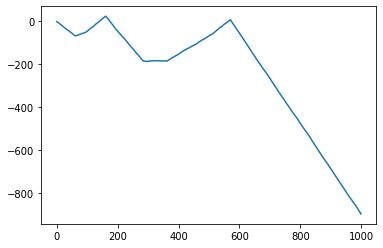

In [6]:
plt.plot(dem_series)

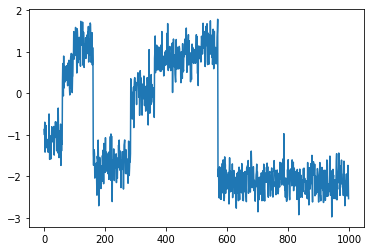

In [7]:
plt.plot(diff_series(dem_series))

Размеется, определение коэффициента наклона для такого ряда задача несложная: шум не перекрывает тренд ряда. Для экспериментов мы увеличим дисперсию шума: 

In [8]:
size = 1000
sl = slopes(size, 400, sd=1)
ln = piecewise_linear(sl)
rw = random_walk(size, sd=1)
series = ln + rw

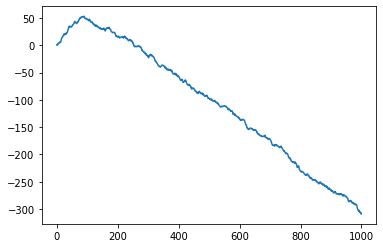

In [9]:
plt.plot(series)

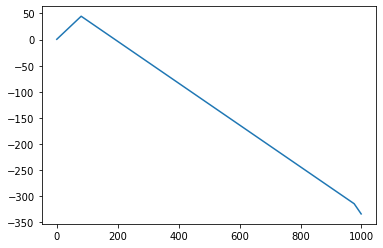

In [10]:
plt.plot(ln)

In [20]:
model = LinearForecaster()
model = model.fit(series)

In [21]:
model.fitted_window

496

In [22]:
pred = model.predict(series)

In [23]:
pred.Slope

-0.4231661739326957

In [45]:
ExperimentResult = namedtuple('ExperimentResult', ['Name', 'AvgMSE', 'AvgWin'])

def run_experiments(size, apfreq, slm=0, slsd=0.1, rwsd=1, test_frac=0.25, repeat=100):
    """
    These are the parameters configuring timeseries generation:
    'size' is the length of a generated time series
    'apfreq' is the APproximate FREQuncy of the slope changing 
    'slm' stands for the 'SLope Mean'
    'slsd' stands for the 'SLope Standard Deviation'
    'rwsd' stands for the 'Random Walk Standard Deviation'
    
    'test_frac' sets the fraction of a series to be used for evaluation of models
    'repeat' sets the number of repetition of the experiment
    
    The result is a tuple of ExperimentResult tuples for LinerPredictor model and PreviousPredictor model
    """
    lin_mse_hist = []
    lin_win_hist = []
    
    prev_mse_hist = []
    
    train_size = size - int(size * test_frac)    
    def gen_time_series():
        series = piecewise_linear(slopes(size, apfreq, mean=slm, sd=slsd)) + random_walk(size, sd=rwsd)
        return series[:train_size], series[train_size:]
    
    def eval_model(model, train, test):
        win = model.fitted_window
        test = np.concatenate([train[-win:], test])
        predict = lambda o: (test[o + win] - model.predict(test[o:(o + win)]).Prediction) ** 2
        predict = np.vectorize(predict)
        return predict(np.arange(len(test) - win - 1)).mean()
        
    def run_experiment():
        train, test = gen_time_series()
        
        lin_model = LinearForecaster(max_window=int(0.8 * len(train)))
        lin_model = lin_model.fit(train)
        lin_mse = eval_model(lin_model, train, test)
        
        prev_model = PreviousForecaster()
        prev_mse = eval_model(prev_model, train, test)
        
        return lin_mse, lin_model.fitted_window, prev_mse, 1 
        
    for i in range(repeat):
        lin_mse, lin_win, prev_mse, _ = run_experiment()
        lin_mse_hist.append(lin_mse)
        lin_win_hist.append(lin_win)
        prev_mse_hist.append(prev_mse)
    
    return (ExperimentResult(Name='Linear', AvgMSE=np.mean(lin_mse_hist), AvgWin=np.mean(lin_win_hist)),
            ExperimentResult(Name='Prev', AvgMSE=np.mean(prev_mse_hist), AvgWin=None))

## Эксперименты

Простейший случай --- линейный тренд без шума. Метод, кторый учитывает тренд, должен давать нулевую погрешность. Метод, предсказывающий послденее значение --- погрешность, равную угловому коэффициенту $a$:

In [41]:
run_experiments(1000, None, slm=1., slsd=0, rwsd=0, test_frac=0.2, repeat=200)

(ExperimentResult(Name='Linear', AvgMSE=0.0, AvgWin=2.0),
 ExperimentResult(Name='Prev', AvgMSE=1.0, AvgWin=1))

Рассмторим случай, когда ряд --- это виенрвоский процесс без трнеда. В таком случае, погрешность для `LinearForecaster` должна быть порядка $\frac{L+1}{L}\sigma^2$, где $L$ --- размер подобранного окна, а $\sigma^2$ --- дисперсия винеровского процесса. Для `PreviousForecaster` ошибка должна быть порядка $\sigma^2$:

In [43]:
run_experiments(1000, None, slm=0, slsd=0, rwsd=2, test_frac=0.2, repeat=200)

(ExperimentResult(Name='Linear', AvgMSE=4.030908115445094, AvgWin=461.33),
 ExperimentResult(Name='Prev', AvgMSE=4.020813315991815, AvgWin=1))

Пусть теперь есть ряд --- это сумма линейного тренда и винеровского процесса. Для линейного предсказания ошибка будет примерно равна $\frac{L+1}{L}\sigma^2$. А для предсказания последнего: $a^2 + \sigma^2$:

In [51]:
run_experiments(1000, None, slm=1, slsd=0, rwsd=1, test_frac=0.2, repeat=200)

(ExperimentResult(Name='Linear', AvgMSE=0.9964976863549521, AvgWin=444.07),
 ExperimentResult(Name='Prev', AvgMSE=1.9891138785696365, AvgWin=None))

Пусть теперь угловые коэффициенты меняются со временем. Ошибка линейного предсказания почти не изменится, а для предсказания --- вырастет:

In [52]:
run_experiments(1000, 200, slm=1, slsd=1, rwsd=1, test_frac=0.2, repeat=200)

(ExperimentResult(Name='Linear', AvgMSE=1.1956394634432803, AvgWin=164.38),
 ExperimentResult(Name='Prev', AvgMSE=3.074884351259463, AvgWin=None))